In [20]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, s, l
from matplotlib import pyplot as plt
import seaborn as sns

In [10]:
np.random.seed(42)

n = 2000 # Reduzimos para termos dados de segmentação mais realistas por item
precos = np.random.uniform(50, 200, n)
tipos_culinaria = np.random.choice(['Italiana', 'Japonesa', 'Brasileira', 'Chinesa'], n)
descontos = np.random.uniform(0, 0.5, n)
lifecycle = np.random.choice(['Aquisicao', 'Retencao', 'Churn'], n)
engajamento = np.random.choice(['Baixo', 'Medio', 'Alto'], n)
sensibilidade_desconto = np.random.randint(0, 10, n)

# Dicionários para simular o efeito de cada variável
culinaria_efeitos = {'Italiana': -0.5, 'Japonesa': 0.5, 'Brasileira': -0.1, 'Chinesa': 0.2}
lifecycle_efeitos = {'Aquisicao': 0.3, 'Retencao': 0.0, 'Churn': -0.4}
engajamento_efeitos = {'Baixo': -0.2, 'Medio': 0.0, 'Alto': 0.4}

# Gerar a taxa de conversão diretamente, com base em um modelo linear
# com a transformação logit
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Simular a taxa de conversão
linear_component = (
    -2  # Intercepto
    + np.log(1 + descontos * 5)  # Efeito do desconto (monotônico)
    - 0.005 * precos # Efeito linear do preço
    + np.array([culinaria_efeitos[t] for t in tipos_culinaria])
    + np.array([lifecycle_efeitos[l] for l in lifecycle])
    + np.array([engajamento_efeitos[e] for e in engajamento])
    + sensibilidade_desconto * 0.1 # Efeito linear da sensibilidade
    + np.random.normal(0, 0.5, n) # Ruído
)

taxa_conversao_simulada = logistic(linear_component)
taxa_conversao_simulada = np.clip(taxa_conversao_simulada, 0.01, 0.99) # Evita 0 e 1, que causam problemas na transformação logit

# Crie o DataFrame
df = pd.DataFrame({
    'taxa_conversao': taxa_conversao_simulada,
    'precos': precos,
    'tipos_culinaria': tipos_culinaria,
    'percentual_desconto': descontos,
    'lifecycle': lifecycle,
    'engajamento': engajamento,
    'bucket_sensibilidade_desconto': sensibilidade_desconto
})

In [11]:
df

,taxa_conversao,precos,tipos_culinaria,percentual_desconto,lifecycle,engajamento,bucket_sensibilidade_desconto
0,0.244909,106.181018,Chinesa,0.336351,Churn,Medio,6
1,0.118542,192.607146,Brasileira,0.398341,Churn,Baixo,5
2,0.109474,159.799091,Brasileira,0.125234,Churn,Baixo,9
3,0.361471,139.798773,Brasileira,0.312437,Retencao,Medio,8
4,0.340397,73.402796,Chinesa,0.285873,Churn,Medio,8
...,...,...,...,...,...,...,...
1995,0.492824,148.543273,Chinesa,0.448699,Aquisicao,Alto,9
1996,0.169213,193.492193,Brasileira,0.059691,Aquisicao,Alto,7
1997,0.316891,60.343702,Japonesa,0.163921,Aquisicao,Medio,4
1998,0.542011,58.558208,Chinesa,0.407873,Aquisicao,Medio,6


In [18]:
numerical_cols = ['percentual_desconto', 'precos', 'bucket_sensibilidade_desconto']
categorical_cols = ['tipos_culinaria', 'lifecycle', 'engajamento']

# Fazer o One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Reorganizar as colunas para ter os termos numéricos primeiro
X = df_encoded[numerical_cols + [col for col in df_encoded.columns if col.startswith(tuple(categorical_cols))]]
y = df_encoded['taxa_conversao']

# Aplicar a transformação logit na variável de resposta
y_logit = np.log(y / (1 - y))

In [21]:

num_numerical_terms = len(numerical_cols)
num_categorical_terms = len(X.columns) - num_numerical_terms

# Crie a fórmula do GAM
gam_formula = s(0) + s(1) + s(2)
for i in range(num_categorical_terms):
    gam_formula += l(num_numerical_terms + i)

# Crie a lista de constraints
constraints = ['monotonic_inc'] + ['none'] * (len(X.columns) - 1)

# Treine o modelo
gam = LinearGAM(gam_formula, constraints=constraints).fit(X, y_logit)

# Resumo do modelo
print("Resumo do Modelo LinearGAM (com One-Hot Encoding):")
print(gam.summary())

Resumo do Modelo LinearGAM (com One-Hot Encoding):
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     43.0471
Link Function:                     IdentityLink Log Likelihood:                                 -2961.6915
Number of Samples:                         2000 AIC:                                             6011.4773
                                                AICc:                                            6013.5072
                                                GCV:                                                0.2625
                                                Scale:                                              0.2523
                                                Pseudo R-Squared:                            

/var/folders/wn/5t00gyl95g987w5nnw16f_x00000gn/T/ipykernel_8383/1867789993.py:17: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


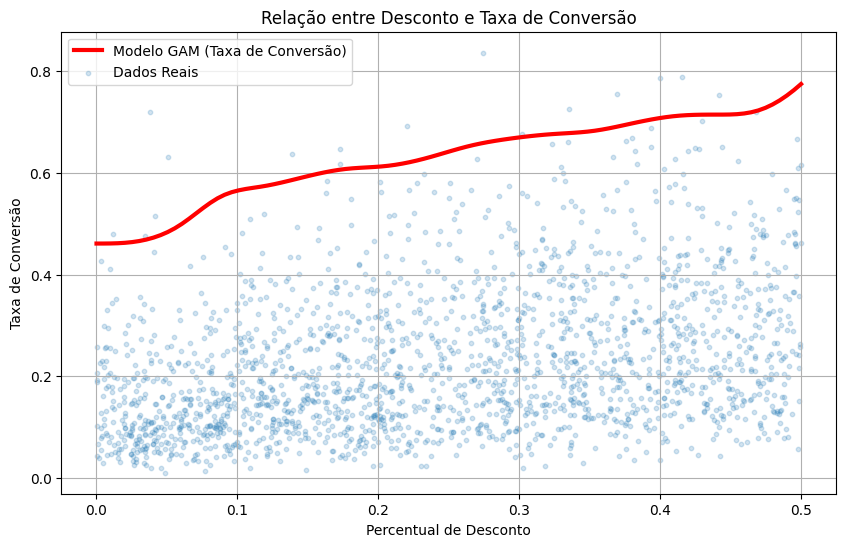

In [22]:
XX = gam.generate_X_grid(term=0)

# Faça as predições no espaço logit
pred_logit = gam.predict(XX)

# Aplique a transformação inversa (inversa do logit) para obter a taxa de conversão
pred_taxa_conversao = 1 / (1 + np.exp(-pred_logit))

# Plotar o resultado
plt.figure(figsize=(10, 6))
plt.plot(XX[:, 0], pred_taxa_conversao, color='red', linewidth=3, label='Modelo GAM (Taxa de Conversão)')
plt.scatter(df['percentual_desconto'], df['taxa_conversao'], alpha=0.2, label='Dados Reais', s=10)
plt.title("Relação entre Desconto e Taxa de Conversão")
plt.xlabel("Percentual de Desconto")
plt.ylabel("Taxa de Conversão")
plt.legend()
plt.grid(True)
plt.show()